# Flare ribbons detection

### Diploma thesis
#### Author: Bc. Lívia Potočňáková

## ENVIROMENT SETUP

#### Import libraries

In [ ]:
import sys
!pip install -r requirements.txt
sys.path.append('./src')

In [4]:
import glob
from datetime import datetime
from PIL import Image
import matplotlib.pylab as plt
import numpy as np
import cv2
import pandas as pd

from astropy.coordinates import SkyCoord
from astropy import units as u
import aiapy
import sunpy
from sunpy.net.helioviewer import HelioviewerClient
from aiapy.calibrate import normalize_exposure, register
from sunpy.coordinates import HeliographicStonyhurst
from sunpy.map import Map

In [ ]:
from utils import plot_imgs, plot_metrics

#### Create HelioviewerClient object

In [2]:
from sunpy.net.helioviewer import HelioviewerClient
hv = HelioviewerClient()

        Use hvpy - https://hvpy.readthedocs.io/en/stable instead. [sunpy.util.logger]


#### Set variables

In [8]:
# folder path for downloading full disc images
folder_name = "./data/"

# folder path for downloading smaller section containing eruptions
# do not use the same folder since files from "folder_name" will be deleted
cutout_folder_name = "./data/segmented/"

In [ ]:
# seed for image shuffle
SEED = 42
# image size for resizing images
IMG_SIZE = 512

## DATA DOWNLOADING
**Data from SDO/NASA were downloaded via Helioviewer API.**

**As source information was used RibbonDB**

In [5]:
# read RibbonDB file
data = pd.read_csv("../ribbondb_v1.0.csv")

In [6]:
# remove rows containing 2010 data
download_info = data.iloc[26:,0:8]

download_info.head()

,INDEX,KEY,TSTART [UT],TPEAK [UT],TFINAL [UT],IXPEAK [W/m^2],LAT [deg],LON [deg]
26,26,20110103_2326_11142_C1.1,2011-01-03 23:26,2011-01-03 23:35,2011-01-03 23:46,0.000001,-14,-5
27,27,20110121_0412_11149_C3.3,2011-01-21 04:12,2011-01-21 04:17,2011-01-21 04:20,0.000003,17,-6
28,28,20110121_1517_11147_C1.1,2011-01-21 15:17,2011-01-21 15:21,2011-01-21 15:25,0.000001,24,-9
29,29,20110121_1638_11149_C2.2,2011-01-21 16:38,2011-01-21 17:12,2011-01-21 17:17,0.000002,18,1
30,30,20110121_2014_11149_C1.3,2011-01-21 20:14,2011-01-21 20:31,2011-01-21 20:39,0.000001,18,4


In [ ]:
# check if folders exist and create them if needed

if not os.path.exists(folder_name):
    os.mkdir(folder_name)
    
if not os.path.exists(cutout_folder_name):
    os.mkdir(cutout_folder_name)

In [ ]:
# go through all rows in download info file
for index, row in download_info.iterrows():
    files = []
    
    # get important info about eruptions
    img_lat = row[' LAT [deg]']
    img_lon = row[' LON [deg]']
    start = row[' TSTART [UT]']
    end = row[' TFINAL [UT]']
    start += (':00')
    end += (':00')
    
    # create a time range for row
    time_range = pd.date_range(start, end, freq='min')
    
    # calculate coordinates for new cut-outs
    top_right = SkyCoord((img_lon-20)*u.deg, (img_lat+20)*u.deg, frame=HeliographicStonyhurst) #nastavit na rozmer stvorca
    bottom_left = SkyCoord((img_lon+20) * u.deg, (img_lat-20)* u.deg, frame=HeliographicStonyhurst)
    
    for i in time_range:
        # get metadata of closest image based on info from time range item
        metadata = hv.get_closest_image(i, observatory="SDO", instrument="AIA", measurement="1600")  
        
        # download full disc image based on metadata
        file = hv.download_jp2(metadata['date'], directory=folder_name, observatory="SDO", instrument="AIA", measurement="1600")
        
        # create new name for the image
        name = str(metadata['date'])[:-4].replace("T", "_").replace(":", "-") + "_AIA1600"
        
        # create Map object and normalize exposure
        file = Map(file)
        file = normalize_exposure(file)
        
        # make cut-out out of full disc 
        aia_sub = file.submap(bottom_left, top_right=top_right)
        
        # save cut-out image in jp2 filetype
        aia_sub.save(cutout_folder_name + name + ".jp2")
        filename = str(file)
        
        # get list of all files in full disc folder and remove them since we only need cut-outs
        files = glob.glob(folder_name+"*")
        for f in files:
            if os.path.isfile(f):
                os.remove(f)

## DATA PREPARATION

**We are creating three arrays - _imgs\_names_, _x_ and _masks_**

* _imgs\_names_ contains image names (so that we can look up eruptions later)

* _x_ contains opened PIL images

* _masks_ are manual segmentation results

**Arrays are then saved to npy files**

In [ ]:
# function for cropping to exact square
# img is a PIL Image 
def crop_img_to_square(img):
    
    if img.width > img.height: 
        size = img.height
    else:
        size = img.width
    img_crop = img.crop((0, 0, size, size))
    
    return img_crop

In [22]:
# get list of downloaded images
imgs = glob.glob(cutout_folder_name + "*.jp2")
len(imgs)

52465

In [ ]:
# shuffle images randomly with set seed
# thanks to this, images used for training will be from different eruptions
np.random.seed(SEED)
np.random.shuffle(imgs)

In [ ]:
# create a smaller subset 
imgs = imgs[:20000]

imgs_list = []

for i in range(len(imgs[0:])):
    # open each image using PIL
    img = Image.open(imgs[i])
    
    # crop to square, convert to grayscale and resize to required size
    # then append to image_list 
    imgs_list.append(np.array(crop_img_to_square(img).convert("L").resize((IMG_SIZE, IMG_SIZE))))

In [ ]:
# create a smaller subset 
imgs = imgs[:20000]

imgs_list = []
imgs_names = []

for i in range(len(imgs[0:])):
     # open each image using PIL
    img = Image.open(imgs[i])
     # crop to square, convert to grayscale and resize to required size
    # then check if the image isn't almost empty and append to image_list 
    img = np.array(crop_img_to_square(img).convert("L").resize((IMG_SIZE, IMG_SIZE)))
    if np.count_nonzero(img >= 0.26) > 200:
        imgs_list.append(img)
        imgs_names.append(imgs[i])

In [7]:
# create array out of normalized image list
x = np.asarray(imgs_list, dtype=np.float32)/255

kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))

masks=[]

for i in range(len(x)):
    ksize = (2,2)
  
    img = cv2.blur(x[i], ksize) 
    
    if np.count_nonzero(img >= 0.26) < 800 :
        img = img > 0.26
    elif np.count_nonzero(img >= 0.26) >= 800 and np.count_nonzero(img >= 0.26) < 1500:
        img = img > 0.28
    else: 
        img = img > 0.32
        
    mask = cv2.morphologyEx(np.float32(img), cv2.MORPH_CLOSE, kernel)
    masks.append(mask)

masks = np.asarray(masks)
masks = masks.reshape(masks.shape[0], masks.shape[1], masks.shape[2], 1)
x = x.reshape(x.shape[0], x.shape[1], x.shape[2], 1)

print(masks.shape, x.shape)

(19977, 512, 512, 1) (19977, 512, 512, 1)


In [21]:
# check for almost black masks - meaning no flare ribbons are visible, or they are very small
all_zeros = []

for i,j in enumerate(masks): 
    if (not j.any()) or (sum(sum(x) for x in masks[i]) <= 200):
        all_zeros.append(i)

11829

In [23]:
# delete images that have black or almost black masks
x = np.delete(x, all_zeros, axis=0)
masks = np.delete(masks, all_zeros, axis=0)
imgs = np.delete(imgs, all_zeros, axis=0)

# check how many images weren't deleted
len(x)

8171

In [24]:
# create smaller sets - 5000 images
x = x[:5000]
masks = masks[:5000]
imgs = imgs[:5000]

In [25]:
# create imgs_names array with only image names (without path) for better clarity
imgs_names = np.char.replace(imgs, '/home/jovyan/data/lightning/LiviaPotocnakova/data/segmented/', '')
imgs_names[0]

'2013-10-22_01-41-04_AIA1600.jp2'

## SAVE PREPARED DATA

In [ ]:
# save all three arrays to npy files

with open('./data/imgs_filtered_5k_512.npy', 'wb') as f:
    np.save(f, x)

with open('./data/masks_filtered_5k_512.npy', 'wb') as f:
    np.save(f, masks)

with open('./data/imgs_names_filtered_5k_512.npy', 'wb') as f:
    np.save(f, imgs_names)

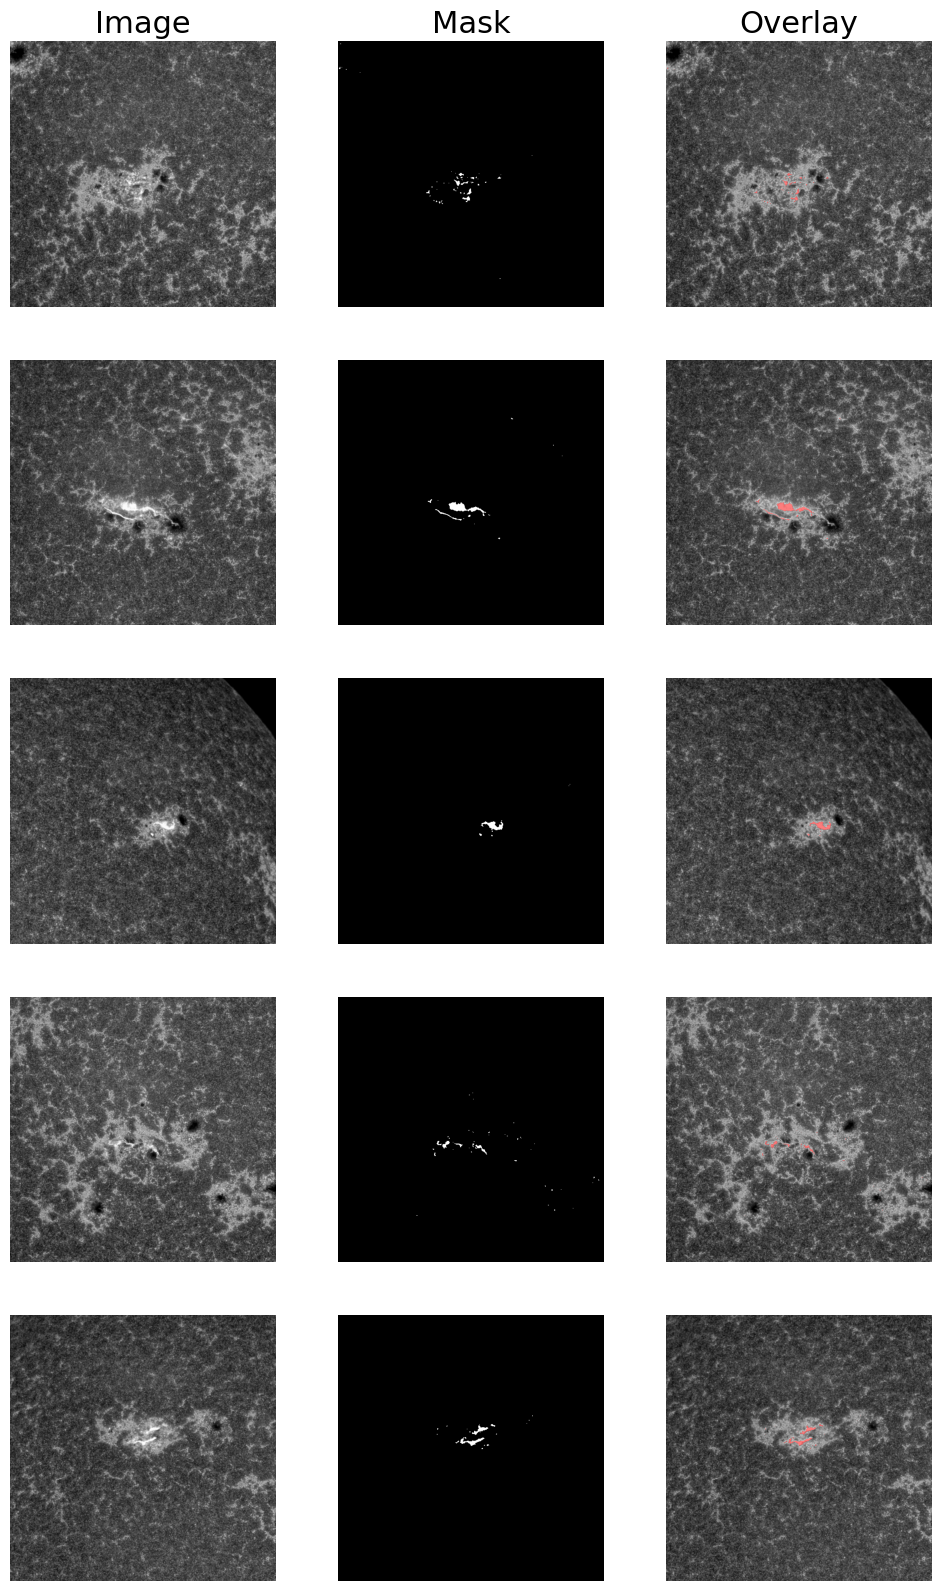

In [33]:
start = 0
n = 5
plot_imgs(imgs=x[start:], masks=masks[start:], n_imgs=n).show()